In [1]:
pip install awswrangler

     |████████████████████████████████| 183 kB 40.4 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 3.4 MB/s  eta 0:00:01
     |████████████████████████████████| 93 kB 1.8 MB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pygeohash

  Created wheel for pygeohash: filename=pygeohash-1.2.0-py2.py3-none-any.whl size=6162 sha256=ac18a701e8f340d305247b6f5235addda78b831bb7f6b7c89eb2e32c1e3b4069
  Stored in directory: /home/ec2-user/.cache/pip/wheels/c3/55/b4/887c04afc06affb11d8a6be5b5a48fef2c517756c9fc37303f
Successfully built pygeohash
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github to learn how to connect to EMR from a notebook instance
spark = (
    SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
#    .config('spark.driver.memory','32G')\
    .master("local[*]")\
    .getOrCreate()
)

spark

In [4]:
# https://sagemaker-examples.readthedocs.io/en/latest/sagemaker-spark/pyspark_mnist/pyspark_mnist_kmeans.html#Loading-the-Data
import boto3

cn_regions = ["cn-north-1", "cn-northwest-1"]
region = boto3.Session().region_name
endpoint_domain = "com.cn" if region in cn_regions else "com"
spark._jsc.hadoopConfiguration().set(
    "fs.s3a.endpoint", "s3.{}.amazonaws.{}".format(region, endpoint_domain)
)

In [5]:
from pyspark.sql.functions import *
import awswrangler as wr

In [6]:
import pandas as pd
from datetime import datetime, timedelta
import pygeohash as pgh
import matplotlib.pyplot as plt

## 1. Import Datasets

### 1.1 Hourly Non-Zero Plane Counts In Cells (individual points in all Pressure Levels)

%%time
hourlyPlaneCountsInCells = spark.read.format('csv')\
        .options(header= 'true', inferSchema= 'true')\
        .load("s3a://partly-cloudy-common-area/proof_of_concept/hourlyPlaneCountsInCells.csv")

hourlyPlaneCountsInCells.write.parquet(
    "s3a://partly-cloudy-common-area/proof_of_concept/hourlyPlaneCountsInCells.parquet", mode= "overwrite", compression= 'gzip')

In [7]:
%%time
hourlyPlaneCountsInCells = spark.read.format('parquet')\
        .load("s3a://partly-cloudy-common-area/proof_of_concept/hourlyPlaneCountsInCells.parquet")

hourlyPlaneCountsInCells.count()

CPU times: user 2.24 ms, sys: 1.35 ms, total: 3.6 ms
Wall time: 4.71 s


1240944

In [8]:
hourlyPlaneCountsInCells = hourlyPlaneCountsInCells.drop("FL")
hourlyPlaneCountsInCells.show()

+---+---+---+----+-------------------+
| Nx| Ny|hPa|hour|hourlyPlanesInCells|
+---+---+---+----+-------------------+
| 88|122|525|   0|                  1|
| 88|122|525|   2|                  2|
| 88|122|525|   4|                  1|
| 88|122|525|  14|                  3|
| 88|122|525|  15|                  1|
| 88|122|525|  21|                  2|
| 88|122|550|  21|                  1|
| 88|122|575|   1|                  1|
| 88|123|175|  17|                  1|
| 88|123|175|  20|                  1|
| 88|123|175|  22|                  1|
| 88|123|200|  13|                  2|
| 88|123|200|  14|                  1|
| 88|123|200|  17|                  1|
| 88|123|200|  22|                  1|
| 88|123|225|   0|                  1|
| 88|123|225|   1|                  1|
| 88|123|225|   3|                  1|
| 88|123|225|   8|                  1|
| 88|123|225|  13|                  1|
+---+---+---+----+-------------------+
only showing top 20 rows



In [9]:
hourlyPlaneCountsInCells.groupBy(col("hPa"))\
                        .agg((count(col("hourlyPlanesInCells")).alias("counts"))).show()

+---+------+
|hPa|counts|
+---+------+
|375| 36656|
|950| 10559|
|300| 48913|
|350| 42884|
|875| 14635|
|625| 19945|
|225|149428|
|725| 16971|
|325| 47760|
|925| 12894|
|500| 23463|
|250|158847|
|650| 20308|
|425| 31235|
|775| 15689|
|675| 21213|
|175| 64028|
|850| 15085|
|900| 13099|
|800| 15774|
+---+------+
only showing top 20 rows



%%time
df = spark.read.format('csv')\
        .options(header= 'true', inferSchema= 'true')\
        .load("s3a://partly-cloudy-rap-csv/2021_05_*.csv") # "s3a://partly-cloudy-rap-csv/2021_05_05_19.csv"; "s3a://partly-cloudy-rap-csv/*.csv"

%%time
df.count()

%%time
df.write.parquet("s3a://partly-cloudy-rap-parquet/2021_05.parquet", mode= "overwrite", compression= 'gzip')

### 1.2 ARTCC (single pressure level) Nx and Ny

In [10]:
%%time
centers = spark.read.format('csv')\
        .options(header= 'true', inferSchema= 'true')\
        .load("s3a://partly-cloudy-common-area/proof_of_concept/rapCellNxNy_ARTCC_intersect.csv")

centers.count()

CPU times: user 1.68 ms, sys: 1.01 ms, total: 2.69 ms
Wall time: 1.27 s


25323

In [11]:
centers.show()

+-----+-----+---+---+
|IDENT| NAME| Nx| Ny|
+-----+-----+---+---+
|  ZMA|MIAMI|233| 28|
|  ZMA|MIAMI|242| 29|
|  ZMA|MIAMI|232| 28|
|  ZMA|MIAMI|241| 29|
|  ZMA|MIAMI|249| 30|
|  ZMA|MIAMI|231| 28|
|  ZMA|MIAMI|240| 29|
|  ZMA|MIAMI|230| 28|
|  ZMA|MIAMI|248| 30|
|  ZMA|MIAMI|239| 29|
|  ZMA|MIAMI|229| 28|
|  ZMA|MIAMI|247| 30|
|  ZMA|MIAMI|238| 29|
|  ZMA|MIAMI|228| 28|
|  ZMA|MIAMI|246| 30|
|  ZMA|MIAMI|227| 28|
|  ZMA|MIAMI|237| 29|
|  ZMA|MIAMI|226| 28|
|  ZMA|MIAMI|245| 30|
|  ZMA|MIAMI|236| 29|
+-----+-----+---+---+
only showing top 20 rows



### 1.3 NOAA RAP Data (6/1/2020 through 5/30/2021)

In [7]:
%%time
rap = spark.read.format('parquet')\
        .load("s3a://partly-cloudy-rap-parquet/*.parquet")

CPU times: user 3.22 ms, sys: 1.74 ms, total: 4.96 ms
Wall time: 14.1 s


In [8]:
rap = rap.withColumn("month", month(col("dateTime")))
rap = rap.withColumn("hour", hour(col("dateTime")))
rap = rap.withColumn("altitude_ft", (1 - (col("hPa")/1013.25)**0.190284) * 145366.4)

rap = rap.withColumn("dateOnly", to_date(col("dateTime")))

time_interval = 6 # 6-hour

myUDF1 = udf(lambda x: x//time_interval * time_interval)
rap = rap.withColumn("period", myUDF1(col('hour')))

In [9]:
%%time
rap.count()

CPU times: user 15.2 ms, sys: 8.18 ms, total: 23.4 ms
Wall time: 2min 44s


7659697500

In [10]:
rap.show(10)

+-------------------+---+------+---+---+------------------+-------------------+-----------+------+------+-----+----+-----------------+----------+------+
|           dateTime|hPa|FLevel| Nx| Ny|               Lat|                Lon|Temperature|RH_ice|IsISSR|month|hour|      altitude_ft|  dateOnly|period|
+-------------------+---+------+---+---+------------------+-------------------+-----------+------+------+-----+----+-----------------+----------+------+
|2021-05-21 06:00:00|150|   440|  1|  1|16.280999999999988|-126.13800000000002|    203.586| 76.34|     0|    5|   6|44301.67362239071|2021-05-21|     6|
|2021-05-21 06:00:00|150|   440|  2|  1|16.322011282850546|-125.95468351809222|    203.711| 76.53|     0|    5|   6|44301.67362239071|2021-05-21|     6|
|2021-05-21 06:00:00|150|   440|  3|  1|  16.3627888393447|-125.77125176429101|    203.836| 74.86|     0|    5|   6|44301.67362239071|2021-05-21|     6|
|2021-05-21 06:00:00|150|   440|  4|  1| 16.40333235182454|-125.58770530205761|   

In [13]:
%%time
totISSRsByHour = rap.filter(col('IsISSR') == 1).groupBy(col("hour")).agg((sum(col("isISSR")).alias("iSSRs")))

totISSRsByHour_pd = totISSRsByHour.toPandas()
totISSRsByHour_pd.sort_values(by= 'hour', axis= 0, ascending= True, inplace= True)
totISSRsByHour_pd.reset_index(inplace= True, drop= True)

CPU times: user 24.9 ms, sys: 13 ms, total: 38 ms
Wall time: 3min 49s


,hour,iSSRs
0,12,3176959
1,22,2496664
2,1,2409673
3,13,3304157
4,6,2295485
5,16,2424901
6,3,2336232
7,20,2047491
8,5,2304289
9,19,2018106


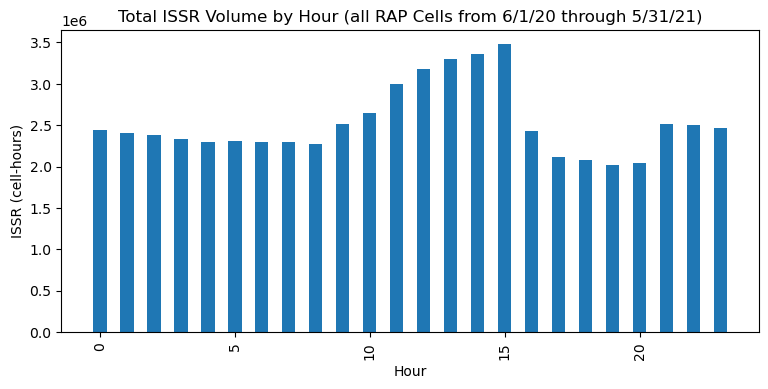

In [19]:
# Graph Total ISSR Volume by Hour (all RAP Cells from 6/1/20 through 5/31/21)
width = 0.5
plt.figure(figsize=(9, 4), dpi=100)
plt.bar(totISSRsByHour_pd['hour'], totISSRsByHour_pd['iSSRs'], width)

plt.title('Total ISSR Volume by Hour (all RAP Cells from 6/1/20 through 5/31/21)')
plt.xlabel('Hour')
plt.ylabel('ISSR (cells)')
plt.xticks(rotation= 90)

plt.show()

In [41]:
%%time
totISSRsByPeriod = rap.filter(col('IsISSR') == 1).groupBy(col("period")).agg((sum(col("isISSR")).alias("iSSRs")))

totISSRsByPeriod_pd = totISSRsByPeriod.toPandas()
totISSRsByPeriod_pd.reset_index(drop= True, inplace= True)

CPU times: user 73.7 ms, sys: 24.8 ms, total: 98.4 ms
Wall time: 3min 25s


In [42]:
totISSRsByPeriod_pd

,period,iSSRs
0,0,14166908
1,18,13619914
2,6,15020971
3,12,17861968


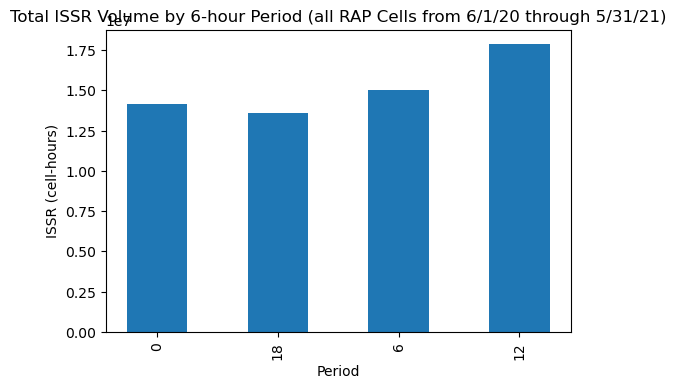

In [43]:
# Graph Total ISSR Volume by 6-hour Period (all RAP Cells from 6/1/20 through 5/31/21)
width = 0.5
plt.figure(figsize=(6, 4), dpi=100)
plt.bar(totISSRsByPeriod_pd['period'], totISSRsByPeriod_pd['iSSRs'], width)

plt.title('Total ISSR Volume by 6-hour Period (all RAP Cells from 6/1/20 through 5/31/21)')
plt.xlabel('Period')
plt.ylabel('ISSR (cell-hours)')
plt.xticks(rotation= 90)

plt.show()

%%time
rap.filter(col('IsISSR') == 1).groupBy(col("FLevel")).agg((sum(col("isISSR")).alias("iSSRs"))).show()

%%time
df.filter(df['IsISSR'] == 1).count()

## 2. Join Datasets

### 2.1 NOAA RAP + ARTCC (Inner Join NOAA RAP with Single Layer ARTCC)

In [16]:
%%time
rap_centers = rap.join(centers, ['Nx', 'Ny'], "inner")
rap_centers.count()

CPU times: user 22.4 ms, sys: 13.4 ms, total: 35.7 ms
Wall time: 4min 49s


2864031300

In [17]:
rap_centers.show(5)

+---+---+-------------------+---+------+------------------+------------------+-----------+------+------+-----+----+-----------------+----------+------+-----+-----+
| Nx| Ny|           dateTime|hPa|FLevel|               Lat|               Lon|Temperature|RH_ice|IsISSR|month|hour|      altitude_ft|  dateOnly|period|IDENT| NAME|
+---+---+-------------------+---+------+------------------+------------------+-----------+------+------+-----+----+-----------------+----------+------+-----+-----+
|224| 28|2021-05-21 06:00:00|150|   440|24.166930399343176|-83.17034642802771|    207.523| 39.27|     0|    5|   6|44301.67362239071|2021-05-21|     6|  ZMA|MIAMI|
|225| 28|2021-05-21 06:00:00|150|   440| 24.15087515658682|-82.97088525760823|    207.648|  37.0|     0|    5|   6|44301.67362239071|2021-05-21|     6|  ZMA|MIAMI|
|226| 28|2021-05-21 06:00:00|150|   440| 24.13455228147526|-82.77147628585855|    207.711|  39.9|     0|    5|   6|44301.67362239071|2021-05-21|     6|  ZMA|MIAMI|
|227| 28|2021-05

df_centers = df_centers.withColumn("dateOnly", to_date(col("dateTime")))

udf2 = udf(lambda x: x//6 * 6)
#df_centers.select('hour', udf2('hour').alias('period')).show(5)
df_centers = df_centers.withColumn("period", udf2(col('hour')))

df_centers.show(5)

### 2.2 NOAA RAP + ADSB (Left Join NOAA RAP with Hourly Non-Zero Plane Counts In Cells)

In [19]:
%%time
rap_planes = rap.join(hourlyPlaneCountsInCells, ['Nx', 'Ny', 'hPa', 'hour'], "left_outer")

rap_planes = rap_planes.withColumn("hourlyPlanesInISSR", (col("IsISSR") * col("hourlyPlanesInCells")))
rap_planes.count()

CPU times: user 38.4 ms, sys: 15.6 ms, total: 54.1 ms
Wall time: 10min 37s


7659697500

In [20]:
rap_planes.show(5)

+---+---+---+----+-------------------+------+------------------+-------------------+-----------+------+------+-----+-----------------+----------+------+-------------------+------------------+
| Nx| Ny|hPa|hour|           dateTime|FLevel|               Lat|                Lon|Temperature|RH_ice|IsISSR|month|      altitude_ft|  dateOnly|period|hourlyPlanesInCells|hourlyPlanesInISSR|
+---+---+---+----+-------------------+------+------------------+-------------------+-----------+------+------+-----+-----------------+----------+------+-------------------+------------------+
|  1|  1|150|   6|2021-05-21 06:00:00|   440|16.280999999999988|-126.13800000000002|    203.586| 76.34|     0|    5|44301.67362239071|2021-05-21|     6|               null|              null|
|  2|  1|150|   6|2021-05-21 06:00:00|   440|16.322011282850546|-125.95468351809222|    203.711| 76.53|     0|    5|44301.67362239071|2021-05-21|     6|               null|              null|
|  3|  1|150|   6|2021-05-21 06:00:00|  

### 2.3 NOAA RAP + ARTCC + ADSB (Left Join "df_centers" in 2.1 with Hourly Non-Zero Plane Counts In Cells in 1.1)

In [18]:
%%time
rap_centers_planes = rap_centers.join(hourlyPlaneCountsInCells, ['Nx', 'Ny', 'hPa', 'hour'], "left_outer")

rap_centers_planes = rap_centers_planes.withColumn("hourlyPlanesInISSR", (col("IsISSR") * col("hourlyPlanesInCells")))
rap_centers_planes.count()

CPU times: user 42.8 ms, sys: 25.1 ms, total: 67.9 ms
Wall time: 9min 11s


2864031300

In [19]:
rap_centers_planes.show(10)

+---+---+---+----+-------------------+------+------------------+------------------+-----------+------+------+-----+-----------------+----------+------+-----+-----+-------------------+------------------+
| Nx| Ny|hPa|hour|           dateTime|FLevel|               Lat|               Lon|Temperature|RH_ice|IsISSR|month|      altitude_ft|  dateOnly|period|IDENT| NAME|hourlyPlanesInCells|hourlyPlanesInISSR|
+---+---+---+----+-------------------+------+------------------+------------------+-----------+------+------+-----+-----------------+----------+------+-----+-----+-------------------+------------------+
|224| 28|150|   6|2021-05-21 06:00:00|   440|24.166930399343176|-83.17034642802771|    207.523| 39.27|     0|    5|44301.67362239071|2021-05-21|     6|  ZMA|MIAMI|               null|              null|
|225| 28|150|   6|2021-05-21 06:00:00|   440| 24.15087515658682|-82.97088525760823|    207.648|  37.0|     0|    5|44301.67362239071|2021-05-21|     6|  ZMA|MIAMI|               null|     

===================================================================================================

## 3. Analysis

### 3.1 Periodic (6-Hour) ISSR Cell Counts by Center (used "rap_centers" in 2.1)

In [23]:
rap_centers.show(5)

+---+---+-------------------+---+------+------------------+------------------+-----------+------+------+-----+----+-----------------+----------+------+-----+-----+
| Nx| Ny|           dateTime|hPa|FLevel|               Lat|               Lon|Temperature|RH_ice|IsISSR|month|hour|      altitude_ft|  dateOnly|period|IDENT| NAME|
+---+---+-------------------+---+------+------------------+------------------+-----------+------+------+-----+----+-----------------+----------+------+-----+-----+
|224| 28|2021-05-21 06:00:00|150|   440|24.166930399343176|-83.17034642802771|    207.523| 39.27|     0|    5|   6|44301.67362239071|2021-05-21|     6|  ZMA|MIAMI|
|225| 28|2021-05-21 06:00:00|150|   440| 24.15087515658682|-82.97088525760823|    207.648|  37.0|     0|    5|   6|44301.67362239071|2021-05-21|     6|  ZMA|MIAMI|
|226| 28|2021-05-21 06:00:00|150|   440| 24.13455228147526|-82.77147628585855|    207.711|  39.9|     0|    5|   6|44301.67362239071|2021-05-21|     6|  ZMA|MIAMI|
|227| 28|2021-05

In [24]:
%%time
issrPeriodByCenter = rap_centers.filter(col('IsISSR') == 1)\
                                .groupBy(col("dateOnly"), col("period"), col("NAME"))\
                                .agg((sum(col("isISSR")).alias("iSSRs")))

issrPeriodByCenter_pd = issrPeriodByCenter.toPandas()
issrPeriodByCenter_pd

CPU times: user 262 ms, sys: 38 ms, total: 300 ms
Wall time: 6min 53s


,dateOnly,period,NAME,iSSRs
0,2020-12-24,12,ATLANTA,10898
1,2021-03-29,12,ALBUQUERQUE,162
2,2020-12-24,6,NEW YORK,889
3,2021-01-02,6,SALT LAKE CITY,4495
4,2021-03-01,18,ATLANTA,2508
...,...,...,...,...
23320,2020-07-21,0,MINNEAPOLIS,3806
23321,2020-07-04,18,HOUSTON,905
23322,2021-01-22,12,WASHINGTON,449
23323,2020-07-27,18,WASHINGTON,34


In [25]:
issrPeriodByCenter_pd['DateTime'] = [pd.Timestamp(issrPeriodByCenter_pd['dateOnly'][i]) + timedelta(hours= int(issrPeriodByCenter_pd['period'][i])) for i in range(len(issrPeriodByCenter_pd))]
issrPeriodByCenter_pd

,dateOnly,period,NAME,iSSRs,DateTime
0,2020-12-24,12,ATLANTA,10898,2020-12-24 12:00:00
1,2021-03-29,12,ALBUQUERQUE,162,2021-03-29 12:00:00
2,2020-12-24,6,NEW YORK,889,2020-12-24 06:00:00
3,2021-01-02,6,SALT LAKE CITY,4495,2021-01-02 06:00:00
4,2021-03-01,18,ATLANTA,2508,2021-03-01 18:00:00
...,...,...,...,...,...
23320,2020-07-21,0,MINNEAPOLIS,3806,2020-07-21 00:00:00
23321,2020-07-04,18,HOUSTON,905,2020-07-04 18:00:00
23322,2021-01-22,12,WASHINGTON,449,2021-01-22 12:00:00
23323,2020-07-27,18,WASHINGTON,34,2020-07-27 18:00:00


output_bucket = 'partly-cloudy-common-area'
outputFileName = 'issrPeriodByCenter_pd.csv' 
wr.s3.to_csv(issrPeriodByCenter_pd, f"s3://{output_bucket}/{outputFileName}", index=False)

### 3.2 Daily ISSR Cell Counts by Center (used "rap_centers" in 2.1)

In [26]:
%%time
issrDailyByCenter = rap_centers.filter(col('IsISSR') == 1)\
                                .groupBy(col("dateOnly"), col("NAME"))\
                                .agg((sum(col("isISSR")).alias("iSSRs")))

issrDailyByCenter_pd = issrDailyByCenter.toPandas()

CPU times: user 57.4 ms, sys: 6.26 ms, total: 63.7 ms
Wall time: 6min 29s


In [27]:
issrDailyByCenter_pd

,dateOnly,NAME,iSSRs
0,2020-12-07,SALT LAKE CITY,3982
1,2021-04-11,BOSTON,5663
2,2020-12-17,CLEVELAND,2395
3,2021-04-26,DENVER,8745
4,2020-06-09,SALT LAKE CITY,1473
...,...,...,...
6726,2020-06-17,JACKSONVILLE,17
6727,2020-08-14,SEATTLE,85
6728,2020-08-23,INDIANAPOLIS,352
6729,2020-08-24,INDIANAPOLIS,91


output_bucket = 'partly-cloudy-common-area'
outputFileName = 'issrDailyByCenter_pd.csv' 
wr.s3.to_csv(issrDailyByCenter_pd, f"s3://{output_bucket}/{outputFileName}", index=False)

===================================================================================================

### 3.3 Hourly Plane Counts in ISSR Cells (used "rap_planes" in 2.2)

In [28]:
rap_planes.show(5)

+---+---+---+----+-------------------+------+------------------+-------------------+-----------+------+------+-----+-----------------+----------+------+-------------------+------------------+
| Nx| Ny|hPa|hour|           dateTime|FLevel|               Lat|                Lon|Temperature|RH_ice|IsISSR|month|      altitude_ft|  dateOnly|period|hourlyPlanesInCells|hourlyPlanesInISSR|
+---+---+---+----+-------------------+------+------------------+-------------------+-----------+------+------+-----+-----------------+----------+------+-------------------+------------------+
|  1|  1|150|   6|2021-05-21 06:00:00|   440|16.280999999999988|-126.13800000000002|    203.586| 76.34|     0|    5|44301.67362239071|2021-05-21|     6|               null|              null|
|  2|  1|150|   6|2021-05-21 06:00:00|   440|16.322011282850546|-125.95468351809222|    203.711| 76.53|     0|    5|44301.67362239071|2021-05-21|     6|               null|              null|
|  3|  1|150|   6|2021-05-21 06:00:00|  

%%time
df_planes.filter(df_planes['hourlyPlanesInISSR'] > 0).count()

In [29]:
%%time

issrPlanesHourly = rap_planes.filter(col('IsISSR') == 1)\
                            .groupBy(col("dateTime")) \
                            .agg((sum(col("hourlyPlanesInISSR")).alias("PlanesInISSR")),
                                 (sum(col("isISSR")).alias("iSSRs")))
                                             
issrPlanesHourly = issrPlanesHourly.toPandas()

CPU times: user 286 ms, sys: 1.84 ms, total: 287 ms
Wall time: 7min 1s


In [30]:
issrPlanesHourly

,dateTime,PlanesInISSR,iSSRs
0,2021-03-30 03:00:00,263.0,7226
1,2020-12-24 11:00:00,2354.0,21674
2,2021-05-19 17:00:00,601.0,3306
3,2020-10-05 08:00:00,383.0,34426
4,2021-02-04 02:00:00,480.0,6431
...,...,...,...
8695,2020-08-11 16:00:00,284.0,2377
8696,2020-07-31 21:00:00,753.0,4146
8697,2021-02-08 11:00:00,23.0,8816
8698,2020-07-08 09:00:00,204.0,8328


output_bucket = 'partly-cloudy-common-area'
outputFileName = 'issrPlanesHourly.csv' 
wr.s3.to_csv(issrPlanesHourly, f"s3://{output_bucket}/{outputFileName}", index=False)

### 3.4 "Super Hot Spot" (used "rap_centers_planes" in 2.3)

In [20]:
rap_centers_planes.show(5)

+---+---+---+----+-------------------+------+------------------+------------------+-----------+------+------+-----+-----------------+----------+------+-----+-----+-------------------+------------------+
| Nx| Ny|hPa|hour|           dateTime|FLevel|               Lat|               Lon|Temperature|RH_ice|IsISSR|month|      altitude_ft|  dateOnly|period|IDENT| NAME|hourlyPlanesInCells|hourlyPlanesInISSR|
+---+---+---+----+-------------------+------+------------------+------------------+-----------+------+------+-----+-----------------+----------+------+-----+-----+-------------------+------------------+
|224| 28|150|   6|2021-05-21 06:00:00|   440|24.166930399343176|-83.17034642802771|    207.523| 39.27|     0|    5|44301.67362239071|2021-05-21|     6|  ZMA|MIAMI|               null|              null|
|225| 28|150|   6|2021-05-21 06:00:00|   440| 24.15087515658682|-82.97088525760823|    207.648|  37.0|     0|    5|44301.67362239071|2021-05-21|     6|  ZMA|MIAMI|               null|     

%%time
periodicRAP_Planes = rap_centers_planes.filter((col('FLevel') >= 200) & (col('FLevel') <= 430))\
                                        .groupBy(col("dateOnly"), col("period"), col("Nx"), col("Ny"), col("NAME")) \
                                        .agg((sum(col("hourlyPlanesInCells")).alias("PlanesInCell")),
                                             (sum(col("hourlyPlanesInISSR")).alias("PlanesInISSR")),
                                             (sum(col("isISSR")).alias("iSSRs")))

In [21]:
%%time
periodicRAP_Planes = rap_centers_planes.filter((col('FLevel') >= 200) & (col('FLevel') <= 430))\
                                        .groupBy(col("dateOnly"), col("period"), col("NAME")) \
                                        .agg((sum(col("hourlyPlanesInCells")).alias("PlanesInCell")),
                                             (sum(col("hourlyPlanesInISSR")).alias("PlanesInISSR")),
                                             (sum(col("isISSR")).alias("iSSRs")))

CPU times: user 3.21 ms, sys: 1.91 ms, total: 5.12 ms
Wall time: 88.4 ms


In [22]:
periodicRAP_Planes.show(5)

+----------+------+--------------+------------+------------+-----+
|  dateOnly|period|          NAME|PlanesInCell|PlanesInISSR|iSSRs|
+----------+------+--------------+------------+------------+-----+
|2020-12-24|    12|       ATLANTA|       20463|        6038|10898|
|2021-03-29|    12|   ALBUQUERQUE|       15877|          53|  162|
|2021-02-03|     0|  INDIANAPOLIS|       14796|           0|    0|
|2020-12-24|     6|      NEW YORK|        6371|           0|  889|
|2021-01-02|     6|SALT LAKE CITY|        2928|           2| 4495|
+----------+------+--------------+------------+------------+-----+
only showing top 5 rows



In [23]:
%%time
periodicRAP_Planes_pd = periodicRAP_Planes.toPandas()
periodicRAP_Planes_pd

CPU times: user 442 ms, sys: 133 ms, total: 575 ms
Wall time: 33min 15s


,dateOnly,period,NAME,PlanesInCell,PlanesInISSR,iSSRs
0,2020-12-24,12,ATLANTA,20463,6038,10898
1,2021-03-29,12,ALBUQUERQUE,15877,53,162
2,2021-02-03,0,INDIANAPOLIS,14796,0,0
3,2020-12-24,6,NEW YORK,6371,0,889
4,2021-01-02,6,SALT LAKE CITY,2928,2,4495
...,...,...,...,...,...,...
29015,2020-07-21,0,MINNEAPOLIS,9471,165,3806
29016,2020-07-04,18,HOUSTON,17422,121,905
29017,2021-01-22,12,WASHINGTON,30737,85,449
29018,2020-07-27,18,WASHINGTON,31060,17,34


periodicRAP_Planes.write.parquet(
    "s3a://partly-cloudy-common-area/proof_of_concept/periodicRAP_Planes.parquet", 
    mode= "overwrite", 
    compression= 'gzip')

periodicRAP_Planes.repartition(1).write.format('.csv').save('s3://partly-cloudy-common-area/proof_of_concept/periodicRAP_Planes.csv')

In [25]:
%%time
periodicRAP_Planes_pd['DateTime'] = [pd.Timestamp(periodicRAP_Planes_pd['dateOnly'][i]) + timedelta(hours= int(periodicRAP_Planes_pd['period'][i])) for i in range(len(periodicRAP_Planes_pd))]

CPU times: user 718 ms, sys: 0 ns, total: 718 ms
Wall time: 720 ms


In [26]:
periodicRAP_Planes_pd['month'] = [periodicRAP_Planes_pd['DateTime'][i].month for i in range(len(periodicRAP_Planes_pd))]
periodicRAP_Planes_pd

,dateOnly,period,NAME,PlanesInCell,PlanesInISSR,iSSRs,DateTime,month
0,2020-12-24,12,ATLANTA,20463,6038,10898,2020-12-24 12:00:00,12
1,2021-03-29,12,ALBUQUERQUE,15877,53,162,2021-03-29 12:00:00,3
2,2021-02-03,0,INDIANAPOLIS,14796,0,0,2021-02-03 00:00:00,2
3,2020-12-24,6,NEW YORK,6371,0,889,2020-12-24 06:00:00,12
4,2021-01-02,6,SALT LAKE CITY,2928,2,4495,2021-01-02 06:00:00,1
...,...,...,...,...,...,...,...,...
29015,2020-07-21,0,MINNEAPOLIS,9471,165,3806,2020-07-21 00:00:00,7
29016,2020-07-04,18,HOUSTON,17422,121,905,2020-07-04 18:00:00,7
29017,2021-01-22,12,WASHINGTON,30737,85,449,2021-01-22 12:00:00,1
29018,2020-07-27,18,WASHINGTON,31060,17,34,2020-07-27 18:00:00,7


In [24]:
periodicRAP_Planes_pd.isnull().sum()

dateOnly        0
period          0
NAME            0
PlanesInCell    0
PlanesInISSR    0
iSSRs           0
dtype: int64

In [ ]:
periodicRAP_Planes_pd.fillna(value= 0, inplace= True)
periodicRAP_Planes_pd.isnull().sum()

%%time
latlon = pd.read_csv("s3://partly-cloudy-common-area/proof_of_concept/latlonRAP.csv")

latlon.count()

%%time
periodicRAP_Planes_pd = pd.merge(periodicRAP_Planes_pd, latlon, how= 'inner', on= ['Nx', 'Ny'])
periodicRAP_Planes_pd

output_bucket = 'partly-cloudy-common-area'
output_directory = 'proof_of_concept'
outputFileName = 'periodicRAP_Planes_pd.csv'
wr.s3.to_csv(periodicRAP_Planes_pd, f"s3://{output_bucket}/{output_directory}/{outputFileName}", index=False)

In [28]:
%%time
periodicRAP_Planes_NxNy = spark.read.format('parquet')\
                                    .load("s3a://partly-cloudy-common-area/proof_of_concept/periodicRAP_Planes.parquet")
periodicRAP_Planes_NxNy.count()

CPU times: user 2.51 ms, sys: 0 ns, total: 2.51 ms
Wall time: 3.93 s


36743673

In [30]:
periodicRAP_Planes_NxNy.show(10)

+----------+------+---+---+------------+------------+------------+-----+
|  dateOnly|period| Nx| Ny|        NAME|PlanesInCell|PlanesInISSR|iSSRs|
+----------+------+---+---+------------+------------+------------+-----+
|2021-05-21|     6|229| 32|       MIAMI|        null|        null|    0|
|2021-05-21|     6|159| 42|     HOUSTON|           4|           0|    0|
|2021-05-21|     6|217| 50|       MIAMI|           4|           0|    0|
|2021-05-21|     6|228| 50|       MIAMI|           5|           0|    0|
|2021-05-21|     6|249| 50|       MIAMI|        null|        null|    0|
|2021-05-21|     6|203| 55|JACKSONVILLE|        null|        null|    0|
|2021-05-21|     6|138| 56|     HOUSTON|           1|           0|    0|
|2021-05-21|     6|160| 61|     HOUSTON|          11|           0|    0|
|2021-05-21|     6|176| 61|     HOUSTON|           2|           0|    0|
|2021-05-21|     6|227| 62|JACKSONVILLE|           8|           0|    0|
+----------+------+---+---+------------+-----------

In [34]:
periodicRAP_Planes_NxNy.orderBy(col("PlanesInISSR").desc()).show(100)

+----------+------+---+---+------------+------------+------------+-----+
|  dateOnly|period| Nx| Ny|        NAME|PlanesInCell|PlanesInISSR|iSSRs|
+----------+------+---+---+------------+------------+------------+-----+
|2020-09-27|    18|229| 63|JACKSONVILLE|         203|         114|   14|
|2020-10-29|    12|236| 80|JACKSONVILLE|         171|         101|   18|
|2020-10-29|    12|234| 77|JACKSONVILLE|         194|         100|   18|
|2020-06-07|    12|231| 63|JACKSONVILLE|         192|          98|   16|
|2020-10-29|    12|235| 78|JACKSONVILLE|         181|          97|   17|
|2020-10-29|    12|233| 75|JACKSONVILLE|         176|          96|   17|
|2020-10-29|    12|233| 74|JACKSONVILLE|         165|          95|   18|
|2020-10-29|    12|235| 79|JACKSONVILLE|         171|          93|   17|
|2020-09-27|    18|229| 62|JACKSONVILLE|         201|          93|   12|
|2021-05-12|    18|239| 85|JACKSONVILLE|         131|          91|   20|
|2020-10-29|    12|234| 76|JACKSONVILLE|         16

In [36]:
periodicRAP_Planes_NxNy_GT0 = periodicRAP_Planes_NxNy.filter(col('PlanesInISSR') > 0)

In [37]:
periodicRAP_Planes_NxNy_GT0.count()

1500381

In [38]:
%%time
periodicRAP_Planes_NxNy_GT0_pd = periodicRAP_Planes_NxNy_GT0.toPandas()
periodicRAP_Planes_NxNy_GT0_pd

CPU times: user 11.1 s, sys: 242 ms, total: 11.4 s
Wall time: 16.4 s


,dateOnly,period,Nx,Ny,NAME,PlanesInCell,PlanesInISSR,iSSRs
0,2021-05-21,6,225,125,CLEVELAND,17,1,3
1,2021-05-20,6,165,64,HOUSTON,3,1,4
2,2021-05-20,6,166,76,FORT WORTH,13,1,1
3,2021-05-20,6,161,85,FORT WORTH,4,2,3
4,2021-05-20,6,225,121,CLEVELAND,17,1,5
...,...,...,...,...,...,...,...,...
1500376,2020-07-06,12,224,77,ATLANTA,28,5,6
1500377,2020-07-06,12,215,78,ATLANTA,32,6,8
1500378,2020-07-06,12,255,117,WASHINGTON,64,1,1
1500379,2021-02-10,18,151,87,FORT WORTH,37,1,3


In [41]:
%%time
latlon = pd.read_csv("s3://partly-cloudy-common-area/proof_of_concept/latlonRAP.csv")

CPU times: user 62.9 ms, sys: 4.67 ms, total: 67.5 ms
Wall time: 187 ms


In [42]:
%%time
periodicRAP_Planes_NxNy_GT0_pd = pd.merge(periodicRAP_Planes_NxNy_GT0_pd, latlon, how= 'inner', on= ['Nx', 'Ny'])
periodicRAP_Planes_NxNy_GT0_pd

CPU times: user 1.11 s, sys: 32.5 ms, total: 1.14 s
Wall time: 1.23 s


,dateOnly,period,Nx,Ny,NAME,PlanesInCell,PlanesInISSR,iSSRs,Lat,Lon
0,2021-05-21,6,225,125,CLEVELAND,17,1,3,41.549106,-80.963614
1,2020-06-01,18,225,125,CLEVELAND,45,1,1,41.549106,-80.963614
2,2020-06-11,0,225,125,CLEVELAND,30,5,2,41.549106,-80.963614
3,2020-06-03,18,225,125,CLEVELAND,45,1,1,41.549106,-80.963614
4,2020-12-25,0,225,125,CLEVELAND,30,7,8,41.549106,-80.963614
...,...,...,...,...,...,...,...,...,...,...
1500376,2021-03-13,12,132,100,KANSAS CITY,1,1,6,37.524418,-102.418848
1500377,2020-10-14,12,120,97,DENVER,6,2,2,36.852220,-105.058036
1500378,2020-09-23,18,88,120,SALT LAKE CITY,1,1,3,40.328876,-112.819566
1500379,2020-10-16,6,43,174,SEATTLE,1,1,4,48.085744,-125.760166


In [43]:
output_bucket = 'partly-cloudy-common-area'
output_directory = 'proof_of_concept'
outputFileName = 'periodicRAP_Planes_NxNy_GT0_pd.csv'
wr.s3.to_csv(periodicRAP_Planes_NxNy_GT0_pd, f"s3://{output_bucket}/{output_directory}/{outputFileName}", index=False)

{'paths': ['s3://partly-cloudy-common-area/proof_of_concept/periodicRAP_Planes_NxNy_GT0_pd.csv'],
 'partitions_values': {}}

============================================================================================================================

In [32]:
%%time
issrsPlanesDailyCenter = rap_centers_planes.filter(col('IsISSR') == 1)\
                                            .groupBy(col("dateOnly"), col("NAME")) \
                                            .agg((sum(col("hourlyPlanesInISSR")).alias("PlanesInISSR")),
                                             (sum(col("isISSR")).alias("iSSRs")))
                                             
issrsPlanesDailyCenter_pd = issrsPlanesDailyCenter.toPandas()

CPU times: user 55.5 ms, sys: 12.4 ms, total: 67.9 ms
Wall time: 6min 47s


In [33]:
issrsPlanesDailyCenter_pd

,dateOnly,NAME,PlanesInISSR,iSSRs
0,2020-12-07,SALT LAKE CITY,40.0,3982
1,2021-04-11,BOSTON,1505.0,5663
2,2020-12-17,CLEVELAND,985.0,2395
3,2021-04-26,DENVER,1385.0,8745
4,2020-06-09,SALT LAKE CITY,36.0,1473
...,...,...,...,...
6726,2020-06-17,JACKSONVILLE,NaN,17
6727,2020-08-14,SEATTLE,32.0,85
6728,2020-08-23,INDIANAPOLIS,328.0,352
6729,2020-08-24,INDIANAPOLIS,43.0,91


In [34]:
issrsPlanesDailyCenter_pd.sort_values(by= ['PlanesInISSR'], axis= 0, ascending= False, inplace= False)

,dateOnly,NAME,PlanesInISSR,iSSRs
3493,2020-10-29,WASHINGTON,17654.0,40158
4681,2020-10-28,WASHINGTON,15766.0,15096
550,2020-10-28,INDIANAPOLIS,14244.0,10975
495,2021-05-27,KANSAS CITY,14126.0,20229
3290,2020-10-04,JACKSONVILLE,13240.0,26486
...,...,...,...,...
6658,2020-12-06,FORT WORTH,NaN,248
6693,2020-07-03,ALBUQUERQUE,NaN,17
6702,2021-01-23,MIAMI,NaN,11
6720,2021-02-05,KANSAS CITY,NaN,7


===================================================================================================

# https://stackoverflow.com/questions/47605552/passing-spark-dataframe-columns-to-geohash-function-pyspark-cannot-convert-co
# https://github.com/vinsci/geohash

udf1 = udf(lambda x,y: pgh.encode(x,y))
df.select('Lat','Lon', udf1('Lat','Lon').alias('geoEncode')).show()

df = df.withColumn("geoEncode", udf1(col('Lat'), col('Lon')))

In [37]:
%%time
#issrDailyVol = df.filter(df['IsISSR'] == 1).groupBy(col('dateTime')).count()

issrHourly = rap.filter(col('IsISSR') == 1).groupBy(col("dateTime")) \
                                        .agg((sum(col("isISSR")).alias("iSSRs")), \
                                             (min(col("altitude_ft")).alias("floor")), \
                                             (max(col("altitude_ft")).alias("ceiling")))
issrHourly_df = issrHourly.toPandas()

CPU times: user 202 ms, sys: 7.73 ms, total: 209 ms
Wall time: 7min 49s


In [38]:
issrHourly_df.sort_values(by= ["dateTime"], axis= 0, ascending= True, inplace= True)

In [39]:
issrHourly_df.reset_index(inplace= True)
issrHourly_df

,index,dateTime,iSSRs,floor,ceiling
0,7897,2020-06-01 00:00:00,7406,23564.338504,41293.296054
1,7195,2020-06-01 01:00:00,7250,23564.338504,41293.296054
2,1910,2020-06-01 02:00:00,6401,23564.338504,41293.296054
3,8406,2020-06-01 03:00:00,6448,23564.338504,41293.296054
4,3731,2020-06-01 04:00:00,7185,23564.338504,41293.296054
...,...,...,...,...,...
8695,892,2021-05-31 19:00:00,5596,26620.205882,41293.296054
8696,7173,2021-05-31 20:00:00,6053,26620.205882,41293.296054
8697,3308,2021-05-31 21:00:00,8466,26620.205882,41293.296054
8698,1074,2021-05-31 22:00:00,8361,26620.205882,41293.296054


In [40]:
%matplotlib inline

plt.style.use('ggplot')

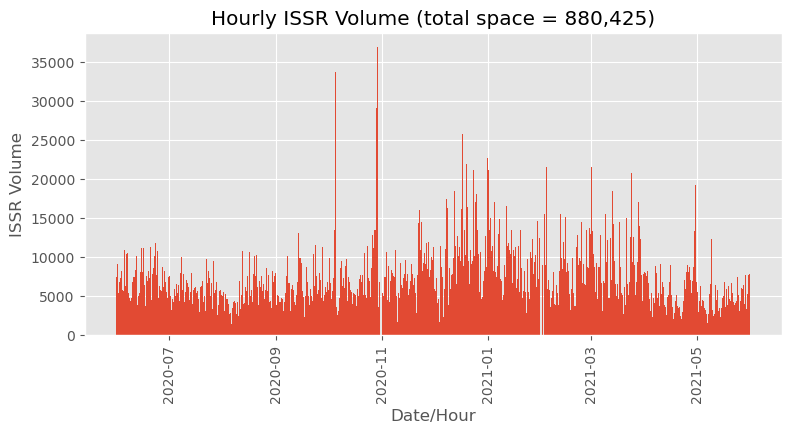

In [41]:
# Graph median speed by Day of Week for all TMC Segments during Morning Rush Hours
width = 0.1
plt.figure(figsize=(9, 4), dpi=100)
plt.bar(issrHourly_df['dateTime'], issrHourly_df['iSSRs'], width)

plt.title('Hourly ISSR Volume (total space = 880,425)')
plt.xlabel('Date/Hour')
plt.ylabel('ISSR Volume')
plt.xticks(rotation= 90)

#plt.xticks(dayOfWeekMedianSpeed_2020['dayOfWeek'] + width/2, dayOfWeekMedianSpeed_2020['dayOfWeek'])
#plt.legend(loc= 'upper right')
plt.show()

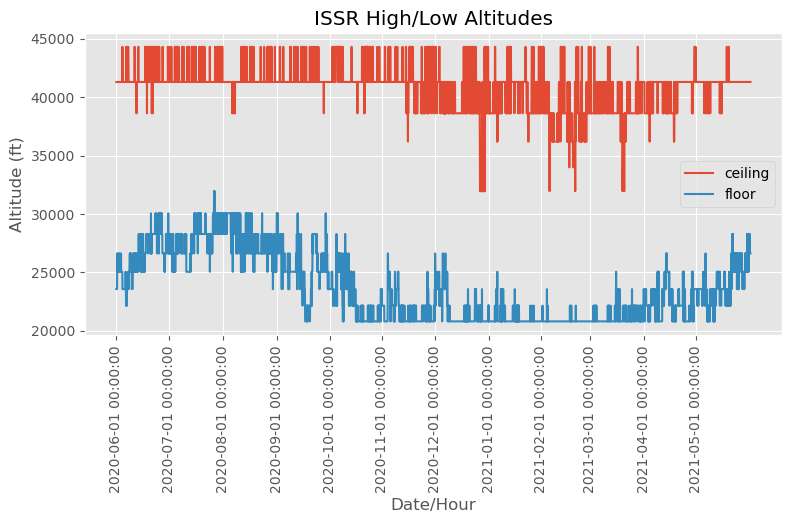

In [42]:
# Graph median speed by Day of Week for all TMC Segments during Morning Rush Hours
plt.figure(figsize=(9, 4), dpi=100)
plt.plot(issrHourly_df.index, issrHourly_df['ceiling'], label= 'ceiling')
plt.plot(issrHourly_df.index, issrHourly_df['floor'], label= 'floor')

tickDateTimes = pd.date_range('2020-05-01 00:00:00', '2021-07-01 00:00:00', freq= pd.offsets.MonthBegin(1))
timesList = [str(t) for t in tickDateTimes]
idxList = [i for i in issrHourly_df.index if str(issrHourly_df['dateTime'][i]) in timesList]

plt.title('ISSR High/Low Altitudes')
plt.xlabel('Date/Hour')
plt.ylabel('Altitude (ft)')
plt.xticks(idxList, list((issrHourly_df['dateTime'][idxList])), rotation= 90)

#plt.xticks(dayOfWeekMedianSpeed_2020['dayOfWeek'] + width/2, dayOfWeekMedianSpeed_2020['dayOfWeek'])
plt.legend(loc= 'right')
plt.show()

In [43]:
months = [issrHourly_df['dateTime'][i].month for i in range(issrHourly_df.shape[0])]

In [44]:
issr_list = list(issrHourly_df['iSSRs'])

In [45]:
issrMonthly = pd.DataFrame({'month': months, 'issrs': issr_list} )

In [46]:
issrMonthly

,month,issrs
0,6,7406
1,6,7250
2,6,6401
3,6,6448
4,6,7185
...,...,...
8695,5,5596
8696,5,6053
8697,5,8466
8698,5,8361


In [47]:
issrMonthly_df = issrMonthly.groupby('month').sum()

In [48]:
issrMonthly_df

,issrs
month,
1,6427921
2,5121588
3,6287976
4,3948918
5,3403485
6,4917631
7,4075105
8,3827339
9,4041602


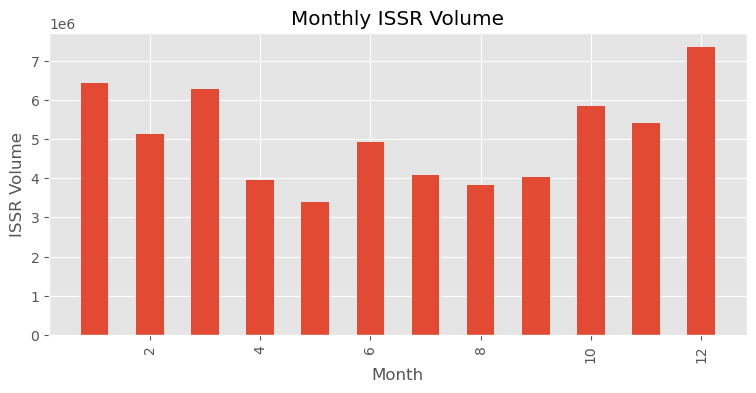

In [49]:
width = 0.5
plt.figure(figsize=(9, 4), dpi=100)
plt.bar(issrMonthly_df.index, issrMonthly_df['issrs'], width)

plt.title('Monthly ISSR Volume')
plt.xlabel('Month')
plt.ylabel('ISSR Volume')
plt.xticks(rotation= 90)

#plt.xticks(dayOfWeekMedianSpeed_2020['dayOfWeek'] + width/2, dayOfWeekMedianSpeed_2020['dayOfWeek'])
#plt.legend(loc= 'upper right')
plt.show()

Below code stores a dataframe to s3 Bucket

In [50]:
%%time
# wr.s3.to_csv(issrDaily_df, 's3://partly-cloudy-common-area/hourly_issr_summary.csv', index=False)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


In [53]:
%%time
issrHours = rap.filter(col('IsISSR') == 1).groupBy(col("Nx"), col("Ny")) \
                                        .agg((sum(col("IsISSR")).alias("iSSR_hours")))
issrHours_df = issrHours.toPandas()

CPU times: user 1.05 s, sys: 24.2 ms, total: 1.07 s
Wall time: 7min 15s


In [54]:
issrHours_df

,Nx,Ny,iSSR_hours
0,201,114,981
1,71,4,720
2,275,19,706
3,58,34,517
4,195,46,962
...,...,...,...
67720,164,1,526
67721,91,99,304
67722,219,16,855
67723,149,23,504


In [55]:
latlonRAP = wr.s3.read_csv(path= 's3://partly-cloudy-common-area/proof_of_concept/latlonRAP.csv')

In [56]:
issrHours_df = pd.merge(issrHours_df, latlonRAP, on= ['Nx', 'Ny'])
issrHours_df

,Nx,Ny,iSSR_hours,Lat,Lon
0,201,114,981,39.971007,-86.716282
1,71,4,720,19.111985,-113.137049
2,275,19,706,21.388344,-73.365253
3,58,34,517,24.178984,-116.518989
4,195,46,962,27.800133,-88.808579
...,...,...,...,...,...
67720,164,1,526,19.711466,-95.193307
67721,91,99,304,36.700235,-111.542597
67722,219,16,855,22.058713,-84.356972
67723,149,23,504,23.689634,-98.191992


output_bucket = 'partly-cloudy-common-area'
outputFileName = 'AnnualTotalISSR_CellHours_df.csv' 
wr.s3.to_csv(issrHours_df, f"s3://{output_bucket}/{outputFileName}", index=False)

In [61]:
issrHoursMonthly = rap.filter(col('IsISSR') == 1).groupBy(col("Nx"), col("Ny"), col('month')) \
                                        .agg((sum(col("IsISSR")).alias("iSSR_hours")))
issrHoursMonthly_df = issrHoursMonthly.toPandas()

In [62]:
issrHoursMonthly_df

,Nx,Ny,month,iSSR_hours
0,217,146,5,39
1,75,3,5,29
2,295,17,5,23
3,21,118,5,39
4,201,168,5,60
...,...,...,...,...
794934,267,39,2,3
794935,65,45,7,3
794936,74,126,7,1
794937,64,35,7,1


In [63]:
latlonRAP = wr.s3.read_csv(path= 's3://partly-cloudy-common-area/proof_of_concept/latlonRAP.csv')
issrHoursMonthly_df = pd.merge(issrHoursMonthly_df, latlonRAP, on= ['Nx', 'Ny'])


output_bucket = 'partly-cloudy-common-area'
outputFileName = 'MonthlyTotalISSR_CellHours_df.csv' 
wr.s3.to_csv(issrHoursMonthly_df, f"s3://{output_bucket}/{outputFileName}", index=False)